# Exercise 2 - Shor's algorithm
## Historical background

In computing, we often measure the performance of an algorithm by how it grows with the size of the input problem. For example, addition has an algorithm that grows linearly with the size of the numbers we're adding. There are some computing problems for which the best algorithms we have grow _exponentially_ with the size of the input, and this means inputs with a relatively modest size are too big to solve using any computer on earth. We're so sure of this, much of the internet's security depends on certain problems being unsolvable.

In 1994, Peter Shor showed that it’s possible to factor a number into its primes efficiently on a quantum computer.[1] This is big news, as the best classical algorithm we know of is one of these algorithms that grows exponentially. And in fact, [RSA encryption](https://en.wikipedia.org/wiki/RSA_(cryptosystem)) relies on factoring large enough numbers being infeasible. To factor integers that are too big for our current classical computers will require millions of qubits and gates, and these circuits are far too big to run on today’s quantum computers successfully.

So how did Lieven M.K. Vandersypen, Matthias Steffen, Gregory Breyta, Costantino S. Yannoni, Mark H. Sherwood and Isaac L. Chuang manage to factor 15 on a quantum computer, all the way back in 2001?![2]

The difficulty in creating circuits for Shor’s algorithm is creating the circuit that computes a controlled $ay \bmod N$. While we know how to create these circuits using a polynomial number of gates, these are still too large for today’s computers. Fortunately, if we know some information about the problem a priori, then we can sometimes ‘cheat’ and create more efficient circuits.

To run this circuit on the hardware available to them, the authors of the above paper found a very simple circuit that performed $7y \bmod 15$. This made the circuit small enough to run on their hardware. By the end of this exercise, you will have created a circuit for $35y \bmod N$ that can be used in Shor’s algorithm and can run on `ibmq_santiago`.

If you want to understand what's going on in this exercise, you should check out the [Qiskit Textbook page on Shor's algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html), but if this is too involved for you, you can complete the exercise without this.

### References
1. Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.
1. Vandersypen, Lieven MK, et al. "Experimental realization of Shor's quantum factoring algorithm using nuclear magnetic resonance." Nature 414.6866 (2001): 883-887.

## tl;dr: Shor’s algorithm

There is an algorithm called [_quantum phase estimation_](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html) that tells us the phase a gate introduces to a certain type of state. For example, inputs to phase estimation algorithm could be the state $|1\rangle$ and the gate $Z$. If the $Z$-gate acts on the state $|1\rangle$, we get back the same state with an added global phase of $\pi$:

$$
Z|1\rangle = -|1\rangle = e^{i\pi} |1\rangle
$$

And the quantum phase estimation algorithm could work this out for us. You can see another example [here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html#2.-Example:-T-gate-).

Shor showed that if we do phase estimation on a gate, $U$, that has the behavior $U|y\rangle = |a y\bmod N\rangle$, we can quickly get some information about $N$’s factors.

## The problem

In this exercise, we will factor 35 by doing phase estimation on a circuit that implements $13y \bmod 35$. The exercise is to create a circuit that does this, and is also small enough to run on `ibmq_santiago`! This is not an easy task, so the first thing we’re going to do is cheat.

A detail of Shor’s algorithm is that our circuit only needs to work on states we can reach through applying $U$ to the starting state $|1\rangle$. I.e. we can use _any_ circuit that has the behavior: 

$$
\begin{aligned}
U|1\rangle &= |13\rangle \\
UU|1\rangle &= |29\rangle \\
UUU|1\rangle &= |27\rangle \\
UUUU|1\rangle &= |1\rangle \\
\end{aligned}
$$

So how can we make this easier for us? Since we only need to correctly transform 4 different states, we can encode these onto two qubits. For this exercise, we will choose to map the 2-qubit computational basis states to the numbers like so:

$$
\begin{aligned}
|1\rangle &\rightarrow |00\rangle \\
|13\rangle &\rightarrow |01\rangle \\
|29\rangle &\rightarrow |10\rangle \\
|27\rangle &\rightarrow |11\rangle \\
\end{aligned}
$$

Why is this “cheating”? Well, to take advantage of this optimization, we need to know all the states $U$ is going to affect, which means we have to compute $ay \bmod N$ until we get back to 1 again, and that means we know the period of $a^x \bmod N$ and can therefore get the factors of $N$. Any optimization like this, in which we use information that would tell us the value $r$, is obviously not going to scale to problems that classical computers can’t solve. 

But the purpose of this exercise is just to verify that Shor’s algorithm does in fact work as intended, and we’re not going to worry about the fact that we cheated to get a circuit for $U$.

<div id='u-definition'></div>
<div class="alert alert-block alert-success">

**Exercise 2a:** Create a circuit ($U$) that performs the transformation:

$$
\begin{aligned}
U|00\rangle &= |01\rangle \\
U|01\rangle &= |10\rangle \\
U|10\rangle &= |11\rangle \\
U|11\rangle &= |00\rangle \\
\end{aligned}
$$

and is controlled by another qubit. The circuit will act on a 2-qubit target register named 'target', and be controlled by another single-qubit register named 'control'. You should assign your finished circuit to the variable '`cu`'.
    
</div>

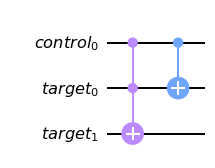

In [1]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, QuantumCircuit
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu = QuantumCircuit(c, t, name="Controlled 13^x mod 35")

# WRITE YOUR CODE BETWEEN THESE LINES - START

cu.ccx(t[0],c[0],t[1])
cu.cx(c[0],t[0])


# WRITE YOUR CODE BETWEEN THESE LINES - END

cu.draw('mpl')

And run the cell below to check your answer:

In [2]:
# Check your answer using following code
from qc_grader import grade_ex2a
grade_ex2a(cu)

Grading your answer for ex2/part1. Please wait...

Congratulations 🎉! Your answer is correct.


Congratulations! You’ve completed the hard part. 

We read the output of the phase estimation algorithm by measuring qubits, so we will need to make sure our 'counting' register contains enough qubits to read off $r$. In our case, $r = 4$, which means we only need $\log_2(4) = 2$ qubits (cheating again because we know $r$ beforehand), but since Santiago has 5 qubits, and we've only used 2 for the 'target' register, we'll use all remaining 3 qubits as our counting register.

To do phase estimation on $U$, we need to create circuits that perform $U^{2^x}$ ($U$ repeated $2^x$ times) for each qubit (with index $x$) in our register of $n$ counting qubits. In our case this means we need three circuits that implement:

$$ U, \; U^2, \; \text{and} \; U^4 $$

So the next step is to create a circuit that performs $U^2$ (i.e. a circuit equivalent to applying $U$ twice).

<div class="alert alert-block alert-success">

**Exercise 2b:** Create a circuit ($U^2$) that performs the transformation:

$$
\begin{aligned}
U|00\rangle &= |10\rangle \\
U|01\rangle &= |11\rangle \\
U|10\rangle &= |00\rangle \\
U|11\rangle &= |01\rangle \\
\end{aligned}
$$

and is controlled by another qubit. The circuit will act on a 2-qubit target register named 'target', and be controlled by another single-qubit register named 'control'. You should assign your finished circuit to the variable '`cu2`'.
</div>

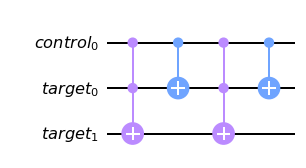

In [3]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu2 = QuantumCircuit(c, t)

# WRITE YOUR CODE BETWEEN THESE LINES - START

cu2.ccx(t[0],c[0],t[1])
cu2.cx(c[0],t[0])
cu2.ccx(t[0],c[0],t[1])
cu2.cx(c[0],t[0])



# WRITE YOUR CODE BETWEEN THESE LINES - END

cu2.draw('mpl')

And you can check your answer below:

In [4]:
# Check your answer using following code
from qc_grader import grade_ex2b
grade_ex2b(cu2)

Grading your answer for ex2/part2. Please wait...

Congratulations 🎉! Your answer is correct.


Finally, we also need a circuit that is equivalent to applying $U$ four times (i.e. we need the circuit $U^4$).  

<div class="alert alert-block alert-success">
    
**Exercise 2c:** Create a circuit ($U^4$) that performs the transformation:

$$
\begin{aligned}
U|00\rangle &= |00\rangle \\
U|01\rangle &= |01\rangle \\
U|10\rangle &= |10\rangle \\
U|11\rangle &= |11\rangle \\
\end{aligned}
$$

and is controlled by another qubit. The circuit will act on a 2-qubit target register named 'target', and be controlled by another single-qubit register named 'control'. You should assign your finished circuit to the variable '`cu4`'. _Hint: The best solution is very simple._
</div>

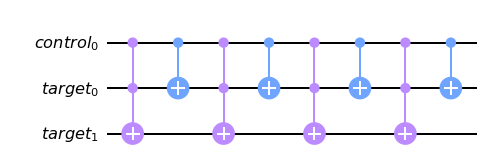

In [5]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu4 = QuantumCircuit(c, t)

# WRITE YOUR CODE BETWEEN THESE LINES - START

cu4.ccx(t[0],c[0],t[1])
cu4.cx(c[0],t[0])
cu4.ccx(t[0],c[0],t[1])
cu4.cx(c[0],t[0])
cu4.ccx(t[0],c[0],t[1])
cu4.cx(c[0],t[0])
cu4.ccx(t[0],c[0],t[1])
cu4.cx(c[0],t[0])



# WRITE YOUR CODE BETWEEN THESE LINES - END

cu4.draw('mpl')

You can check your answer using the code below:

In [6]:
# Check your answer using following code
from qc_grader import grade_ex2c
grade_ex2c(cu4)

Grading your answer for ex2/part3. Please wait...

Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-success">

**Exercise 2 final:** Now we have controlled $U$, $U^2$ and $U^4$, we can combine this into a circuit that carries out the quantum part of Shor’s algorithm.

The initialization part is easy: we need to put the counting register into the state $|{+}{+}{+}\rangle$ (which we can do with three H-gates) and we need the target register to be in the state $|1\rangle$ (which we mapped to the computational basis state $|00\rangle$, so we don’t need to do anything here). We'll do all this for you.

_Your_ task is to create a circuit that carries out the controlled-$U$s, that will be used in-between the initialization and the inverse quantum Fourier transform. More formally, we want a circuit:


$$
CU_{c_0 t}CU^2_{c_1 t}CU^4_{c_2 t}
$$

Where $c_0$, $c_1$ and $c_2$ are the three qubits in the ‘counting’ register, $t$ is the ‘target’ register, and $U$ is as <a href="#u-definition">defined in the first part of this exercise</a>. In this notation, $CU_{a b}$ means $CU$ is controlled by $a$ and acts on $b$. An easy solution to this is to simply combine the circuits `cu`, `cu2` and `cu4` that you created above, but you will most likely find a more efficient circuit that has the same behavior!
    
</div>
<div class="alert alert-block alert-danger">
    
Your circuit can only contain [CNOTs](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html) and single qubit [U-gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html). Your score will be the number of CNOTs you use (less is better), as multi-qubit gates are usually much more difficult to carry out on hardware than single-qubit gates. If you're struggling with this requirement, we've included a line of code next to the submission that will convert your circuit to this form, although you're likely to do better by hand.
    
</div>

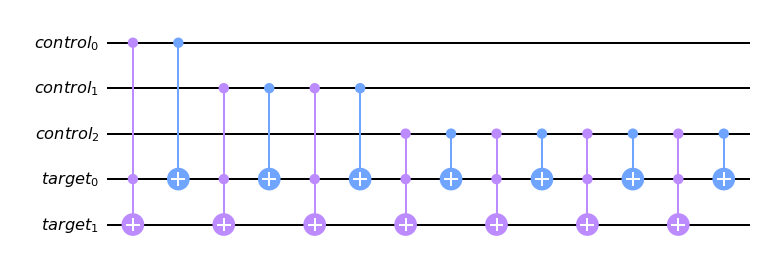

In [7]:
# Code to combine your previous solutions into your final submission
cqr = QuantumRegister(3, 'control')
tqr = QuantumRegister(2, 'target')
cux = QuantumCircuit(cqr, tqr)
solutions = [cu, cu2, cu4]
for i in range(3):
    cux = cux.compose(solutions[i], [cqr[i], tqr[0], tqr[1]])
cux.draw('mpl')

In [9]:
# Check your answer using following code
from qc_grader import grade_ex2_final
# Uncomment the two lines below if you need to convert your circuit to CNOTs and single-qubit gates
from qiskit import transpile
cux = transpile(cux, basis_gates=['cx','u'])
grade_ex2_final(cux)

Grading your answer for ex2/part4. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 49.
Feel free to submit your answer.



In [19]:
import os
print(os.getenv('QXToken'))
#and set it if needed
os.environ['QXToken'] = 'e647d11cb21e1afa62cd295c1bef096c5cb9b8d57b208b117b05d799dd7534a1bcd0dfc65882935585cf3310af41cf2c7e681267976662f1507ec58a44ac26cb'

6ba96bfeedc78c79d5fb2d2179bd920674970099c9ebb59f479e96b49fbd0ad7bb0143d6224116e2bd219788b8e46a401806e2c64ceeb69cfd227df20d5a5e3f


Once you're happy with the circuit, you can submit it below:

In [20]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex2_final
submit_ex2_final(cux)

Submitting your answer for ex2/part4. Please wait...
Success 🎉! Your answer has been submitted.


Congratulations! You've finished the exercise. Read on to see your circuit used to factor 35, and see how it performs .

## Using your circuit to factorize 35

The code cell below takes your submission for the exercise and uses it to create a circuit that will give us $\tfrac{s}{r}$, where $s$ is a random integer between $0$ and $r-1$, and $r$ is the period of the function $f(x) = 13^x \bmod 35$.

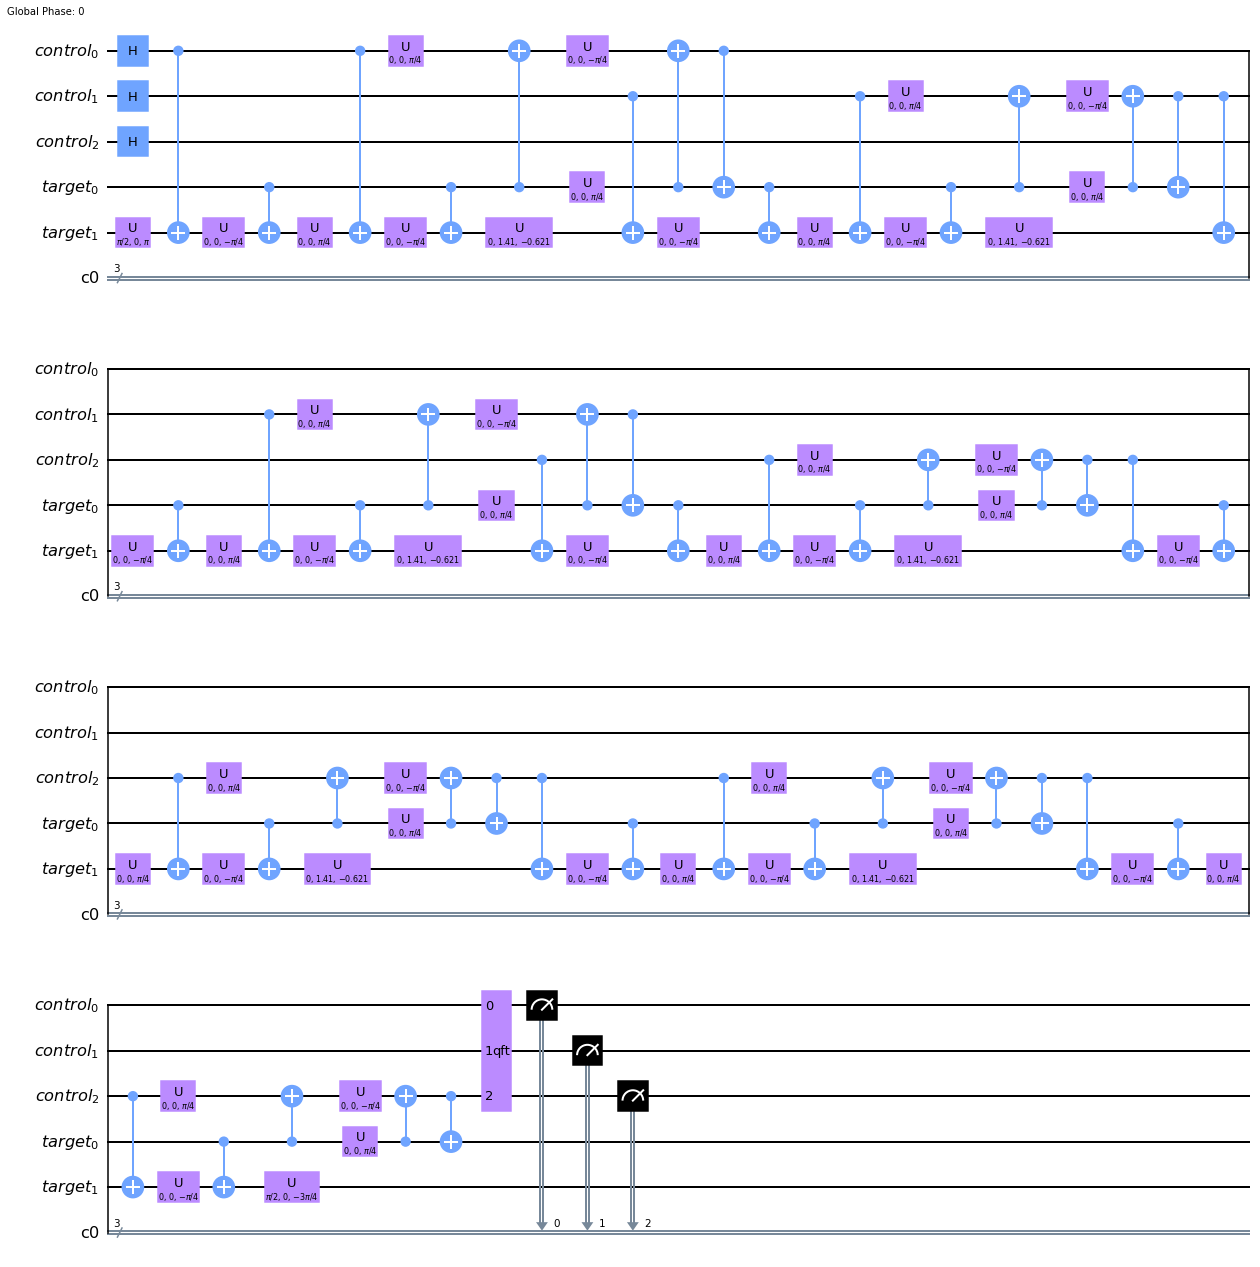

In [11]:
from qiskit.circuit.library import QFT
from qiskit import ClassicalRegister
# Create the circuit object
cr = ClassicalRegister(3)
shor_circuit = QuantumCircuit(cqr, tqr, cr)

# Initialise the qubits
shor_circuit.h(cqr)

# Add your circuit
shor_circuit = shor_circuit.compose(cux)

# Perform the inverse QFT and extract the output
shor_circuit.append(QFT(3, inverse=True), cqr)
shor_circuit.measure(cqr, cr)
shor_circuit.draw('mpl')

Let's transpile this circuit and see how large it is, and how many CNOTs it uses:

In [12]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
qasm_sim = Aer.get_backend('aer_simulator')
tqc = transpile(shor_circuit, basis_gates=['u', 'cx'], optimization_level=3)
print(f"circuit depth: {tqc.depth()}")
print(f"circuit contains {tqc.count_ops()['cx']} CNOTs")

circuit depth: 84
circuit contains 44 CNOTs


And let's see what we get:

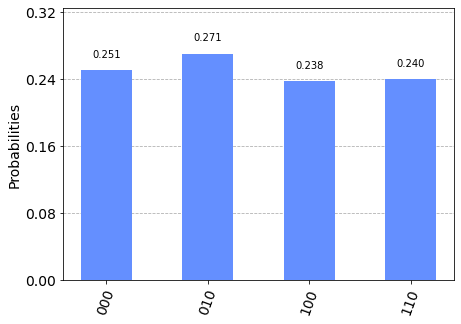

In [13]:
counts = qasm_sim.run(tqc).result().get_counts()
plot_histogram(counts)

Assuming everything has worked correctly, we should see equal probability of measuring the numbers $0$, $2$, $4$ and $8$. This is because phase estimation gives us $2^n \cdot \tfrac{s}{r}$, where $n$ is the number of qubits in our counting register (here $n = 3$, $s$ is a random integer between $0$ and $r-1$, and $r$ is the number we're trying to calculate). Let's convert these to fractions that tell us $s/r$ (this is something we can easily calculate classically):

In [14]:
from fractions import Fraction
n = 3  # n is number of qubits in our 'counting' register
# Cycle through each measurement string
for measurement in counts.keys():
    # Convert the binary string to an 'int', and divide by 2^n
    decimal = int(measurement, 2)/2**n
    # Use the continued fractions algorithm to convert to form a/b
    print(Fraction(decimal).limit_denominator())

1/2
0
3/4
1/4


We can see the denominator of some of the results will tell us the correct answer $r = 4$. We can verify $r=4$ quickly:

In [15]:
13**4 % 35

1

So how do we get the factors from this? There is then a high probability that the greatest common divisor of $N$ and either $a^{r/2}-1$ or $a^{r/2}+1$ is a factor of $N$, and the greatest common divisor is also something we can easily calculate classically.

In [16]:
from math import gcd # Greatest common divisor
for x in [-1, 1]:
    print(f"Guessed factor: {gcd(13**(4//2)+x, 35)}")

Guessed factor: 7
Guessed factor: 5


We only need to find one factor, and can use it to divide $N$ to find the other factor. But in this case, _both_ $a^{r/2}-1$ or $a^{r/2}+1$ give us $35$'s factors. We can again verify this is correct:

In [17]:
7*5

35

## Running on `ibmq_santiago`

We promised this would run on Santiago, so here we will show you how to do that. In this example we will use a simulated Santiago device for convenience, but you can switch this out for the real device if you want:

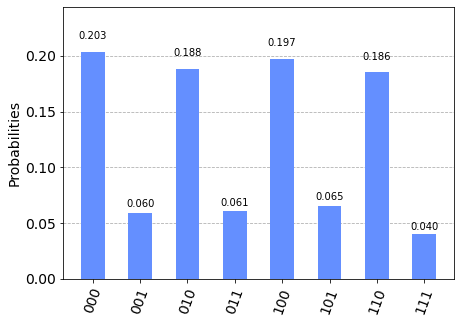

In [18]:
from qiskit.test.mock import FakeSantiago
from qiskit import assemble
from qiskit.visualization import plot_histogram
santiago = FakeSantiago()
real_device = False

## Uncomment this code block to run on the real device
#from qiskit import IBMQ
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#santiago = provider.get_backend('ibmq_santiago')
#real_device = True

# We need to transpile for Santiago
tqc = transpile(shor_circuit, santiago, optimization_level=3)

if not real_device:
    tqc = assemble(tqc)

# Run the circuit and print the counts
counts = santiago.run(tqc).result().get_counts()
plot_histogram(counts)

If your score was low enough, you should see we have a high probability of measuring $0$, $2$, $4$ or $8$ as we saw with the perfect simulation. You will see some extra results due to inaccuracies in the processor and unwanted things interacting with our qubits. This 'noise' gets worse the longer our circuit is, as longer computation time means more time for unwanted interactions, and more gates means more potential errors. This is why we needed to cheat to create the smallest circuit possible.

In the near future, our quantum systems will improve enough that we can start using more advanced error mitigation techniques to overcome these problems, which will mean we can run large enough circuits that we can [perform Shor's algorithm without cheating](https://arxiv.org/pdf/quant-ph/0205095.pdf).

## Additional information

**Created by:** Frank Harkins

**Version:** 1.0.0